<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/ClassificationWithPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook does PCA on MNIST**




In [1]:
from google.colab import drive

ROOT = "/content/gdrive"

drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%pylab inline
import pickle
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
pca_path = './gdrive/My Drive/PCA/mnist/'

In [5]:
from sklearn.decomposition import PCA

mask = np.where(np.var(x_train, axis=0)>0.)
num  = len(mask[0])
print(num)
for ii in range(10):
  indices = np.where(targets_train==ii)
  x_train_class = x_train[indices]
  cut_train = x_train_class[:,mask[0]]
  pca = PCA(svd_solver='full',n_components=num)
  pca.fit(cut_train)  

  pickle.dump([pca,mask], open(pca_path+'pca_on_%d_num_comp_full.pkl'%ii,'wb'))



717


In [0]:
import numpy.linalg as lg
def get_probability_of_data(logdet,Cinv,data):
  d    = len(data)
  Cinv_d = np.einsum('jk,...k->...j',Cinv,data)
  logprob = -0.5*logdet-0.5*d*np.log((2*np.pi))-0.5*np.einsum('ij,ij->i',data, Cinv_d)
  return logprob

In [0]:
# do classification
nums = [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
acc1 = np.zeros((len(nums),10))
acc2 = np.zeros((len(nums),10))

for ll in range(len(nums)):
  num = nums[ll] 
  print(num, ll)
  for ii in range(10):
    print(ii)
    indices = np.where(targets_test==ii)
    x_test_class =x_test[indices]
    logprob1=[]
    logprob2=[]
    for jj in range(10):
      pca, mask= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
      cut_test = x_test_class[:,mask[0]]
      sing     = pca.singular_values_[0:num]
      R        = pca.components_[0:num]
      sigma2_1 = pca.explained_variance_[num]
      sigma2_2 = np.mean(pca.explained_variance_[num::])
      
      C_       = np.dot(R.T,np.dot(np.diag(sing), R))+np.eye(len(R.T))*sigma2_1
      sign ,logdetC = lg.slogdet(C_)
      logprob1+=[get_probability_of_data(logdetC,lg.inv(C_),cut_test)]
      
      C_       = np.dot(R.T,np.dot(np.diag(sing), R))+np.eye(len(R.T))*sigma2_2
      sign ,logdetC = lg.slogdet(C_)
      logprob2+=[get_probability_of_data(logdetC,lg.inv(C_),cut_test)]
      
    logprob1=np.asarray(logprob1)
    correct = len(np.where(np.argsort(logprob1, axis=0)[-1]==ii)[0])
    acc_1 = np.float(correct)/np.float(len(x_test_class))
    print('acc 1:', acc_1)
    acc1[ll,ii]=acc_1
    
    logprob2=np.asarray(logprob2)
    correct = len(np.where(np.argsort(logprob2, axis=0)[-1]==ii)[0])
    acc_2 = np.float(correct)/np.float(len(x_test_class))
    print('acc 2:', acc_2)
    acc2[ll,ii]=acc_2
    
pickle.dump(acc1, open(pca_path+'accuracies1_testset.pkl','wb'))
pickle.dump(acc2, open(pca_path+'accuracies2_testset.pkl','wb'))

In [0]:
acc1test = pickle.load(open(pca_path+'accuracies1_testset.pkl','rb'))
acc2test = pickle.load(open(pca_path+'accuracies2_testset.pkl','rb'))

In [0]:
# nums = [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
# for ii in range(10):
#   plt.semilogx(nums, acc1test[:,ii], marker='o',label='class %d'%ii)

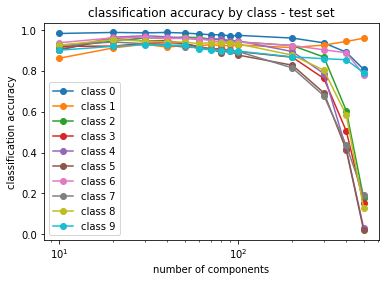

In [46]:
nums = [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
plt.title('classification accuracy by class - test set')
for ii in range(10):
  plt.semilogx(nums, acc2test[:,ii], marker='o',label='class %d'%ii)
  plt.xlabel('number of components')
  plt.ylabel('classification accuracy')
  plt.legend()

No handles with labels found to put in legend.


0.9500304766779235


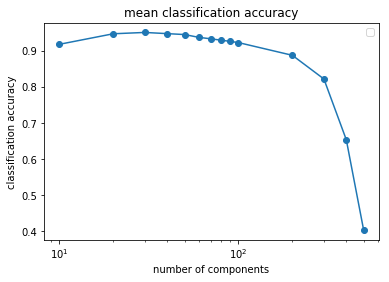

In [19]:
nums = [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
plt.figure()
plt.title('mean classification accuracy')
plt.semilogx(nums, np.mean(acc2test,axis=1), marker='o')
print(max(np.mean(acc2test,axis=1)))
plt.xlabel('number of components')
plt.ylabel('classification accuracy')
plt.legend()
plt.show()

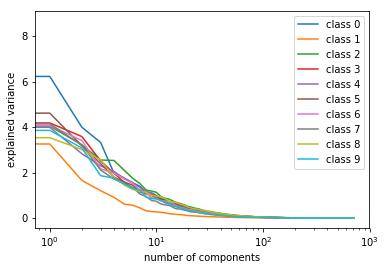

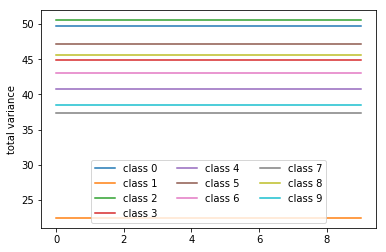

In [28]:
plt.figure()
for jj in range(10):
      pca, mask= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
      plt.semilogx(pca.explained_variance_, label='class %d'%jj)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.legend()
plt.show()

plt.figure()
for jj in range(10):
      pca, mask= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
      plt.plot(np.ones((10))*np.sum(pca.explained_variance_), label='class %d'%jj)
plt.ylabel('total variance')
plt.legend(ncol=3)
plt.show()

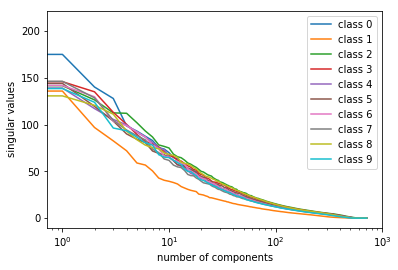

In [31]:
plt.figure()
for jj in range(10):
      pca, mask= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
      plt.semilogx(pca.singular_values_, label='class %d'%jj)
plt.xlabel('number of components')
plt.ylabel('singular values')
plt.legend()
plt.show()

In [34]:
# # do classification
# nums = [10,20,30,40,60,70,90,100,300,500,700]
# acc1 = np.zeros((len(nums),10))
# acc2 = np.zeros((len(nums),10))

# for ll in range(len(nums)):
#   num = nums[ll] 
#   print(num, ll)
#   for ii in range(10):
#     print(ii)
#     indices      = np.where(targets_train==ii)
#     x_test_class = x_train[indices]
#     logprob1=[]
#     logprob2=[]
#     for jj in range(10):
#       pca, mask= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
#       cut_test = x_test_class[:,mask[0]]
#       sing     = pca.singular_values_[0:num]
#       R        = pca.components_[0:num]
#       sigma2_1 = pca.explained_variance_[num]
#       sigma2_2 = np.mean(pca.explained_variance_[num::])
      
#       C_       = np.dot(R.T,np.dot(np.diag(sing), R))+np.eye(len(R.T))*sigma2_1
#       sign ,logdetC = lg.slogdet(C_)
#       logprob1+=[get_probability_of_data(logdetC,lg.inv(C_),cut_test)]
      
#       C_       = np.dot(R.T,np.dot(np.diag(sing), R))+np.eye(len(R.T))*sigma2_2
#       sign ,logdetC = lg.slogdet(C_)
#       logprob2+=[get_probability_of_data(logdetC,lg.inv(C_),cut_test)]
      
#     logprob1=np.asarray(logprob1)
#     correct = len(np.where(np.argsort(logprob1, axis=0)[-1]==ii)[0])
#     acc_1 = np.float(correct)/np.float(len(x_test_class))
#     print('acc 1:', acc_1)
#     acc1[ll,ii]=acc_1
    
#     logprob2=np.asarray(logprob2)
#     correct = len(np.where(np.argsort(logprob2, axis=0)[-1]==ii)[0])
#     acc_2 = np.float(correct)/np.float(len(x_test_class))
#     print('acc 2:', acc_2)
#     acc2[ll,ii]=acc_2
    
# pickle.dump(acc1, open(pca_path+'accuracies1_trainset.pkl','wb'))
# pickle.dump(acc2, open(pca_path+'accuracies2_trainset.pkl','wb'))

10 0
0
acc 1: 0.0
acc 2: 0.9778994322789943
1
acc 1: 1.0
acc 2: 0.8599859105318775
2
acc 1: 0.0
acc 2: 0.9281400966183575
3
acc 1: 0.0
acc 2: 0.9043324838267006
4
acc 1: 0.0
acc 2: 0.8960691500308705
5
acc 1: 0.0
acc 2: 0.9043497558810475
6
acc 1: 0.0
acc 2: 0.9472833770955362
7
acc 1: 0.0
acc 2: 0.9219323671497585
8
acc 1: 0.0
acc 2: 0.9202808756712102
9
acc 1: 0.0
acc 2: 0.8899358460304732
20 1
0
acc 1: 0.03102189781021898
acc 2: 0.9829683698296837
1
acc 1: 1.0
acc 2: 0.9011976047904192
2
acc 1: 0.0
acc 2: 0.9573268921095008
3
acc 1: 0.0
acc 2: 0.9111938835522446
4
acc 1: 0.0
acc 2: 0.9611031076353159
5
acc 1: 0.0
acc 2: 0.9427430093209055
6
acc 1: 0.004645526156332054
acc 2: 0.9571803676025046
7
acc 1: 0.010821256038647344
acc 2: 0.9466666666666667
8
acc 1: 0.0
acc 2: 0.9405204460966543
9
acc 1: 0.0018043303929430633
acc 2: 0.919206094627105
30 2
0
acc 1: 0.41585563665855635
acc 2: 0.9835766423357665
1
acc 1: 1.0
acc 2: 0.9207467418104966
2
acc 1: 0.0
acc 2: 0.964573268921095
3
acc 

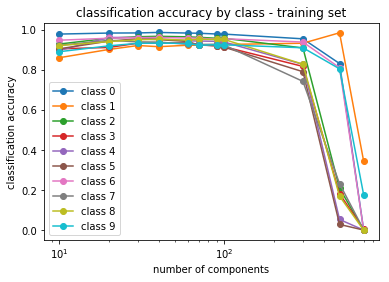

In [45]:
acc1train=pickle.load(open(pca_path+'accuracies1_trainset.pkl','rb'))
acc2train=pickle.load(open(pca_path+'accuracies2_trainset.pkl','rb'))
nums = np.asarray([10,20,30,40,60,70,90,100,300,500,700])

plt.figure()
plt.title('classification accuracy by class - training set')
for ii in range(10):
  plt.semilogx(nums, acc2train[:,ii], marker='o',label='class %d'%ii)
  plt.xlabel('number of components')
  plt.ylabel('classification accuracy')
  plt.legend()
plt.show()

# plt.figure()
# plt.title('classification accuracy by class')
# for ii in range(10):
#   plt.semilogx(nums, acc1train[:,ii], marker='o',label='class %d'%ii)
#   plt.xlabel('number of components')
#   plt.ylabel('classification accuracy')
#   plt.legend()
# plt.show()

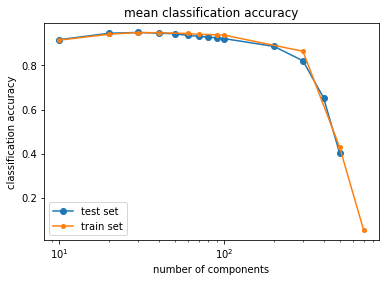

In [41]:

plt.figure()
plt.title('mean classification accuracy')
nums = [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
plt.semilogx(nums, np.mean(acc2test,axis=1), marker='o', label='test set')
nums = [10,20,30,40,60,70,90,100,300,500,700]
plt.semilogx(nums, np.mean(acc2train,axis=1), marker='o',markersize=4,label='train set')
plt.xlabel('number of components')
plt.ylabel('classification accuracy')
plt.legend()
plt.show()

0
1


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


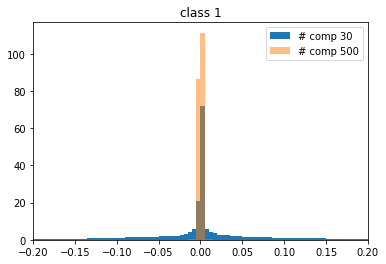

0
1


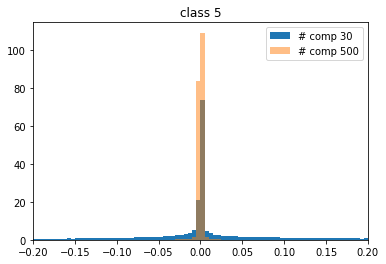

In [118]:
# do classification
nums = [30,500]

hists= np.zeros((len(nums),10,2,80))

for ii in [1,5]:
  plt.figure()
  plt.title('class %d'%ii)
  for ll in range(len(nums)):
    print(ll)
    num = nums[ll] 
    indices = np.where(targets_test==ii)
    x_test_class =x_test[indices]
    pca, mask= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
    cut_test = x_test_class[:,mask[0]]
    R        = pca.components_[0:num]
    Rd = np.einsum('ij,...j->...i', R,cut_test)
    RRd= np.einsum('ij,...j->...i', R.T, Rd)
    _ = plt.hist(((RRd - cut_test)).flatten(), range=(-0.2,0.2),bins=80, normed=True, alpha=(len(nums)-ll)/len(nums),label='# comp %d'%num)
  plt.xlim(-0.2,0.2)
  plt.legend()
  #plt.yscale('log')
  plt.show()


0


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


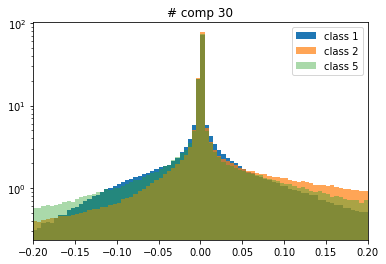

1


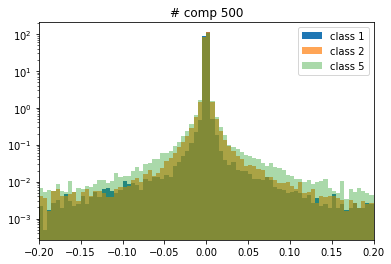

In [120]:
# do classification
nums = [30,500]

hists= np.zeros((len(nums),10,2,80))
for ll in range(len(nums)):
  print(ll)
  num = nums[ll] 
  plt.figure()
  plt.title('# comp %d'%num)
  alpha=1.
  for ii in [1,2,5]:
    indices = np.where(targets_test==ii)
    x_test_class =x_test[indices]
    pca, mask= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
    cut_test = x_test_class[:,mask[0]]
    R        = pca.components_[0:num]
    Rd = np.einsum('ij,...j->...i', R,cut_test)
    RRd= np.einsum('ij,...j->...i', R.T, Rd)
    _ = plt.hist(((RRd - cut_test)).flatten(), range=(-0.2,0.2),bins=80, normed=True,alpha=alpha, label='class %d'%ii)
    alpha-=0.3
  plt.yscale('log')
  plt.xlim(-0.2,0.2)
  plt.legend()
  plt.show()
